## Homework01: Three headed network in PyTorch

This notebook accompanies the [week02 seminar](https://github.com/girafe-ai/ml-mipt/blob/advanced/week02_CNN_n_Vanishing_gradient/week02_CNN_for_texts.ipynb). Refer to that notebook for more comments.

All the preprocessing is the same as in the classwork. *Including the data leakage in the train test split (it's still for bonus points).*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from tqdm import  tqdm
from collections import Counter

If you have already downloaded the data on the Seminar, simply run through the next cells. Otherwise uncomment the next cell (and comment the another one ;)

In [2]:
#uncomment and run this cell, if you don't have data locally yet.

!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  62.3M      0  0:00:01  0:00:01 --:--:--  164M
Train_rev1.csv


In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col = None)

data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data_for_autotest = data[-5000:]
data = data[:-5000]

In [4]:
from sklearn.model_selection import train_test_split
# see task above
tokenizer = nltk.tokenize.WordPunctTokenizer()

def normalize(text):
    text = str(text).lower()
    return ' '.join(tokenizer.tokenize(text))
    
data[text_columns] = data[text_columns].applymap(normalize)

print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

data_train, data_val = train_test_split(data, test_size = 0.2, random_state = 42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object
Train size =  191814
Validation size =  47954


In [5]:
token_counts = Counter()# <YOUR CODE HERE>
for txt in data_train[text_columns].values.flatten():
    token_counts.update(txt.split(' ')) 

In [6]:
min_count = 10
import re
# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = list(set([re.sub(r'[^\w\s]','', token) for token, count in token_counts.items() if count >= min_count]))
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
# assert len(tokens) in range(32000, 35000)
# assert 'me' in tokens
assert UNK in tokens
print("Correct!")

token_to_id = {token: idx for idx, token in enumerate(tokens)}
assert isinstance(token_to_id, dict)
# assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Vocabulary size: 30034
Correct!
Correct!


In [7]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len = None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[ 9361 26521  1654     1     1]
 [13118  2266     1     1     1]
 [24289  8821     0 13291  9358]]


In [9]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype = np.float32, sparse = False)
categorical_vectorizer.fit(data_train[categorical_columns].apply(dict, axis = 1))
# categorical_vectorizer.transform(data_val[categorical_columns].apply(dict, axis = 1))


DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.


#### Here comes the simple one-headed network from the seminar. 

In [10]:
def make_batch(data, max_len = None, word_dropout = 0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [11]:
a = make_batch(data_train[:3], max_len = 10)

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [12]:
import torch
from torch import nn
import torch.nn.functional as F

In [13]:
# You will need these to make it simple

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

To generate minibatches we will use simple pyton generator.

In [14]:
def iterate_minibatches(data, batch_size = 256, shuffle = True, cycle = False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [15]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

### Actual homework starts here
__Your ultimate task is to code the three headed network described on the picture below.__ 
To make it closer to the real world, please store the network code in file `network.py` in this directory. 

#### Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [16]:
!wget https://raw.githubusercontent.com/alexunderch/Bachelor_materials/main/ml-mipt_advanced/network.py -nc

--2021-03-21 07:50:33--  https://raw.githubusercontent.com/alexunderch/Bachelor_materials/main/ml-mipt_advanced/network.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3024 (3.0K) [text/plain]
Saving to: ‘network.py’

network.py          100%[===================>]   2.95K  --.-KB/s    in 0s      

2021-03-21 07:50:33 (50.7 MB/s) - ‘network.py’ saved [3024/3024]



In [17]:
import network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Re-run this cell if you updated the file with network source code
import imp
imp.reload(network)

<module 'network' from '/content/network.py'>

In [21]:
model = network.ThreeInputsNet(
    n_tokens = len(tokens),
    n_cat_features = len(categorical_vectorizer.vocabulary_),

    # this parameter defines the number of the inputs in the layer,
    # which stands after the concatenation. In should be found out by you.
    concat_number_of_features = 8 * 128 + 512).to(device)

In [22]:
testing_batch, _ = next(iterate_minibatches(data_train, 3))
testing_batch = [
    torch.tensor(testing_batch['Title'], dtype = torch.long).to(device),
    torch.tensor(testing_batch['FullDescription'], dtype = torch.long).to(device),
    torch.tensor(testing_batch['Categorical']).to(device)]

In [23]:
assert model(testing_batch).detach().cpu().numpy().shape == torch.Size([3, 1])
assert model(testing_batch).dtype == torch.float32
print('Seems fine!')

Seems fine!


Now train the network for a while (100 batches would be fine).

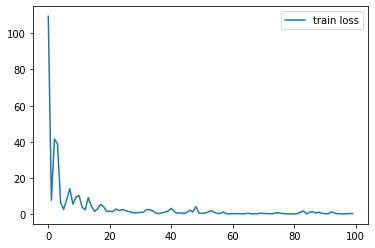

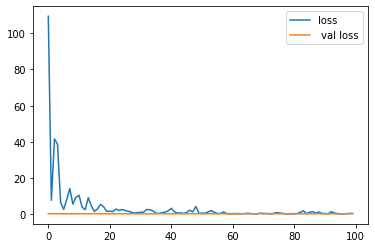

In [24]:
# Training pipeline comes here (almost the same as for the simple_model)
epochs = 1
num_batches_stop = 100
from IPython.display import clear_output
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() 

history = []
val_history = []
for epoch_num in range(epochs):
    _ = model.train()
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train)):
        if idx >= num_batches_stop: break
        batch = (torch.tensor(batch['Title'], dtype = torch.long).to(device),
                 torch.tensor(batch['FullDescription'], dtype = torch.long).to(device),
                 torch.tensor(batch['Categorical'], dtype = torch.float).to(device))
        target = torch.tensor(target).to(device)

        opt.zero_grad()
        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        loss = loss_func(predictions, target)
        loss.backward()
        opt.step()
        history.append(loss.item())

        if (idx + 1) % 10 == 0:
              clear_output(True)
              plt.plot(history, label = 'train loss')
              plt.legend(loc = 'best')
              plt.show()

    _ = model.eval()
    with torch.no_grad():
      for idx, (batch, target) in enumerate(iterate_minibatches(data_val, shuffle = False)):
          if idx >= num_batches_stop: break

          batch = (torch.tensor(batch['Title'], dtype = torch.long).to(device),
                  torch.tensor(batch['FullDescription'], dtype = torch.long).to(device),
                  torch.tensor(batch['Categorical'], dtype = torch.float).to(device))
          target = torch.tensor(target).to(device)

          predictions = model(batch)
          predictions = predictions.view(predictions.size(0))
          loss = loss_func(predictions, target) 
          val_history.append(loss.item())

plt.plot(history, label = 'loss')
plt.plot(val_history, label = ' val loss')
plt.legend(loc = 'best')

Now, to evaluate the model it can be switched to `eval` state.

In [25]:
model.eval()

ThreeInputsNet(
  (title_emb): Embedding(30034, 64)
  (title_conv1): Conv1d(64, 128, kernel_size=(2,), stride=(1,), padding=(1,))
  (title_relu1): ReLU()
  (title_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (title_amp): AdaptiveMaxPool1d(output_size=2)
  (full_emb): Embedding(30034, 64)
  (full_conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (full_relu1): ReLU()
  (full_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (full_conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (full_relu2): ReLU()
  (full_bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (full_amp): AdaptiveMaxPool1d(output_size=2)
  (category_in): Linear(in_features=21232, out_features=1024, bias=True)
  (category_bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (category_dropout): Dropout(p=0.33, inplace=False)
  (category_out): Linear(in_fea

In [26]:
def generate_submission(model, data, batch_size = 256, name = "", three_inputs_mode = True):
    squared_error = 0.; abs_error = 0.; num_samples = 0.0
    output_list = []
    for batch_x, batch_y in tqdm(iterate_minibatches(data, batch_size = batch_size, shuffle = False)): 
        if three_inputs_mode:
            batch = [
                torch.tensor(batch_x['Title'], dtype = torch.long),
                torch.tensor(batch_x['FullDescription'], dtype = torch.long),
                torch.tensor(batch_x['Categorical'])
            ]
        else:
            batch = torch.tensor(batch_x['FullDescription'], dtype=torch.long)

        batch_pred = model(batch)[:, 0].detach().numpy()
        
        output_list.append((list(batch_pred), list(batch_y)))
        
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    

    batch_pred = [c for x in output_list for c in x[0]]
    batch_y = [c for x in output_list for c in x[1]]
    output_df = pd.DataFrame(list(zip(batch_pred, batch_y)), columns=['batch_pred', 'batch_y'])
    output_df.to_csv('submission.csv', index=False)


In [27]:
generate_submission(model.cpu(), data_for_autotest, name = 'Submission')
print('Submission file generated')

20it [00:17,  1.14it/s]

Submission results:
Mean square error: 2.16706
Mean absolute error: 1.22779
Submission file generated


__To hand in this homework, please upload `network.py` file with code and `submission.csv` to the google form.__